In [4]:
!pip install gensim

import nltk
from nltk.stem import *

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# Prepare list of stopwords for removal
stopwords = set(nltk.corpus.stopwords.words('english'))

import pandas as pd
import numpy as np
# NMF implementation in sklearn
from sklearn.decomposition import NMF 

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer


from scipy import linalg # For linear algebra operations
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(suppress=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Preprocess

In [6]:
import nltk
from nltk import ne_chunk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

file = 'The Little Prince.txt'

with open(file, "r") as file1:
  text = file1.read()
  part_of_speech = nltk.pos_tag(word_tokenize(text))

list_nn = []
for i in part_of_speech:
  if i[1] in ['NN', 'NNP']:
    if i not in list_nn:
      list_nn.append(i)
    # print(i)

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_nltk = set(stopwords.words('english'))


candi_chara = []
for i in list_nn:
  c1 = lemmatizer.lemmatize(i[0].lower(), pos='n')
  c2 = lemmatizer.lemmatize(c1, pos='v')
  c3 = lemmatizer.lemmatize(c2, pos='a')
  if i not in stop_words_nltk:
    candi_chara.append(c3)

# remove = []
# for i in list_nn:
#   if i[0] in stop_words_nltk:
#     remove.append(i)
#   for key in dict_3.keys():
#     if i[0] in dict_3[key]:
#       remove.append(i)
#       continue
#   for keysp in dict_spacy.keys():
#     if i[0] in dict_spacy[keysp]:
#       remove.append(i)
#       continue
# after_remove = []
# for i in list_nn:
#   if i not in remove:
#     after_remove.append(i)

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
docs = []
docs_sen = []
last = 0
with open(file, "r", encoding="utf-8") as file1:
    FileContent = file1.read()
    FileContent = FileContent.lower() # lowercase
    for i in range(len(FileContent)):
      if FileContent[i] == 'c' and FileContent[i+1] == 'h' and FileContent[i+2] == 'a' and FileContent[i+3] == 'p':
        docs.append(FileContent[last:i+1]) 
        docs_sen.append(FileContent[last-1:i]) 
        last = i+1


In [9]:
sen_cha = {} # key:chapter; value:list of sentence
for i in range(1, len(docs_sen)):
  sen_cha[i] = []
  cha_now = docs_sen[i] # the content of the chapter i
  count = 0
  for lett in range(len(cha_now)):
    if cha_now[lett] == '\n':
      if cha_now[count:lett].strip('\n') != '':
        sen_cha[i].append(cha_now[count:lett].strip('\n'))
      # print(cha_now[count:lett].strip('\n\n'))
      count = lett

# Extract key character in each chapter

In [12]:
### n-gram = 3
nltk.download('universal_tagset')

dict_tag2cat = {'ADJ':'a', 'NOUN':'n', 'ADP':' ', 'VERB':'v', 'ADV':' ',
      'ADP':' ', 'CONJ':' ', 'INTJ':' ', 'PRON':'n'}
cate = list(dict_tag2cat.keys())

after_lem_cha = {}
for cha in range(1, len(docs_sen)):
  list_sen = sen_cha[cha] 
  after_list_sen = []
  # Lemmatization
  for sen in range(len(list_sen)):
    words = nltk.tokenize.word_tokenize(list_sen[sen]) # get list of words
    after_lem_pos_tag = nltk.pos_tag(words, tagset='universal')
    after_lem = []
    for i in after_lem_pos_tag:
      cate_now = i[1]
      if cate_now in cate:
        if dict_tag2cat[i[1]] != ' ':
          after_lem.append(lemmatizer.lemmatize(i[0],pos=dict_tag2cat[i[1]]))
          # a for Adjective； v for Verb； n for Noun； r for adverb;
        else:
          after_lem.append(lemmatizer.lemmatize(i[0]))
      else:
        after_lem.append(lemmatizer.lemmatize(i[0]))
    after_list_sen.append(' '.join(str(e) for e in after_lem))
  after_lem_cha[cha] = after_list_sen

  df = pd.DataFrame(after_lem_cha[cha], columns=['text'])
  # print(df.head())

  # Initialize TFIDF Vectorizer
  vect= TfidfVectorizer(
      stop_words='english' # Remove Stopwords
  )

  # Apply Transformation
  X = vect.fit_transform(df.text)

  # Create an NMF instance with 4 components
  model = NMF(n_components=1, init='nndsvd', random_state=42)

  # Fit the model
  model.fit(X)

  # Features Matrix
  nmf_features = model.transform(X)

  # Components Matrix
  components_df = pd.DataFrame(model.components_, 
                              columns=vect.get_feature_names_out())

  terms =  list(vect.get_feature_names_out())

  # Top 10 words of importance in each of the topics

  for topic in range(components_df.shape[0]):
      value_list = []
      topic_df = components_df.iloc[topic]
      print(f'For topic {cha} the words with the highest value are:')
      # print(topic_df.nlargest(20))
      # print(topic_df.nlargest(10).keys())
      topic_now = list(topic_df.nlargest(10).keys())
      after_nn = []
      for tt in topic_now:
        if tt in candi_chara:
          after_nn.append(tt)
      print(after_nn)
      print('\n')
  key_chara[cha] = after_nn

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


For topic 1 the words with the highest value are:
['draw', 'boa', 'constrictor', 'number', 'elephant', 'look', 'make']


For topic 2 the words with the highest value are:
['make', 'sheep', 'draw', 'look', 'matter', 'answer']


For topic 3 the words with the highest value are:
['thing', 'plane', 'little', 'fly', 'come', 'prince', 'sky', 'tie', 'planet']




/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


For topic 4 the words with the highest value are:
['planet', 'asteroid', 'little', 'prince', 'astronomer', 'house']


For topic 5 the words with the highest value are:
['sheep', 'little', 'eat', 'baobab', 'prince', 'planet', 'shrub']


For topic 6 the words with the highest value are:
['wait', 'sunset', 'time', 'watch', 'day', 'little', 'ask']


For topic 7 the words with the highest value are:
['thorn', 'flower', 'yes', 'sheep', 'eat', 'don']


For topic 8 the words with the highest value are:
['little', 'prince', 'flower', 'horrify', 'weed', 'planet', 'make', 'screen']


For topic 9 the words with the highest value are:
['flower', 'goodbye', 'cold', 'volcano', 'clean', 'little', 'cough']


For topic 10 the words with the highest value are:
['little', 'prince', 'king', 'ask', 'yawn', 'planet', 'question', 'look']


For topic 11 the words with the highest value are:
['little', 'prince', 'hat', 'clap', 'hand', 'ask', 'hello']


For topic 12 the words with the highest value are:
['drunka

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


For topic 17 the words with the highest value are:
['snake', 'prince', 'little', 'good', 'desert', 'silent', 'earth']


For topic 18 the words with the highest value are:
['goodbye', 'little', 'prince', 'flower', 'hello', 'ask', 'people']


For topic 19 the words with the highest value are:
['answer', 'echo', 'hello', 'case', 'just', 'little', 'prince', 'friend', 'need']


For topic 20 the words with the highest value are:
['hello', 'garden', 'prince', 'flower', 'bloom', 'little', 'just']




/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


For topic 21 the words with the highest value are:
['fox', 'little', 'prince', 'yes', 'mean', 'look', 'friend', 'time']


For topic 22 the words with the highest value are:
['little', 'prince', 'ask', 'hello', 'signalman']


For topic 23 the words with the highest value are:
['hello', 'little', 'prince', 'merchant', 'minute', 'ask', 'fountain']


For topic 24 the words with the highest value are:
['little', 'prince', 'desert', 'fox', 'friend', 'make', 'look']


For topic 25 the words with the highest value are:
['prince', 'little', 'blush', 'look', 'promise', 'drink']


For topic 26 the words with the highest value are:
['laugh', 'little', 'man', 'star', 'hear', 'afraid', 'prince']




In [14]:
### n-gram = 1
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('universal_tagset')

dict_tag2cat = {'ADJ':'a', 'NOUN':'n', 'ADP':' ', 'VERB':'v', 'ADV':' ',
      'ADP':' ', 'CONJ':' ', 'INTJ':' ', 'PRON':'n'}
cate = list(dict_tag2cat.keys())

after_lem_cha = {}
extract_chara = {}
for cha in range(1, len(docs_sen)):
  list_sen = sen_cha[cha] 
  after_list_sen = []
  # Lemmatization
  for sen in range(len(list_sen)):
    words = nltk.tokenize.word_tokenize(list_sen[sen]) # get list of words
    after_lem_pos_tag = nltk.pos_tag(words, tagset='universal')
    after_lem = []
    for i in after_lem_pos_tag:
      cate_now = i[1]
      if cate_now in cate:
        if dict_tag2cat[i[1]] != ' ':
          after_lem.append(lemmatizer.lemmatize(i[0],pos=dict_tag2cat[i[1]]))
          # a for Adjective； v for Verb； n for Noun； r for adverb;
        else:
          after_lem.append(lemmatizer.lemmatize(i[0]))
      else:
        after_lem.append(lemmatizer.lemmatize(i[0]))
    after_list_sen.append(' '.join(str(e) for e in after_lem))
  after_lem_cha[cha] = after_list_sen

  df = pd.DataFrame(after_lem_cha[cha], columns=['text'])
  # print(df.head())

  # Initialize TFIDF Vectorizer
  vect= TfidfVectorizer(
      ngram_range=(1, 3), # Include unigrams, bi-grams and tri-grams
      stop_words='english' # Remove Stopwords
  )

  # Apply Transformation
  X = vect.fit_transform(df.text)

  # Create an NMF instance with 4 components
  model = NMF(n_components=1, init='nndsvd', random_state=42)

  # Fit the model
  model.fit(X)

  # Features Matrix
  nmf_features = model.transform(X)

  # Components Matrix
  components_df = pd.DataFrame(model.components_, 
                              columns=vect.get_feature_names_out())

  terms =  list(vect.get_feature_names_out())

  # Top 10 words of importance in each of the topics

  for topic in range(components_df.shape[0]):
      value_list = []
      topic_df = components_df.iloc[topic]
      print(f'For topic {cha} the words with the highest value are:')
      # print(topic_df.nlargest(20))
      print(topic_df.nlargest(10).keys())
      print('\n')
  extract_chara[cha] = topic_df.nlargest(10).keys()

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


For topic 1 the words with the highest value are:
Index(['draw', 'boa', 'boa constrictor', 'constrictor', 'number',
       'draw number', 'grown', 'grown ups', 'ups', 'elephant'],
      dtype='object')


For topic 2 the words with the highest value are:
Index(['make drawing', 'drawing', 'make', 'look', 'bend', 'bend drawing',
       'bend drawing look', 'closely', 'closely tiny', 'closely tiny oh'],
      dtype='object')


For topic 3 the words with the highest value are:
Index(['guide', 'nose', 'nose guide', 'suppose', 'suppose nose',
       'suppose nose guide', 'guide far', 'let', 'let nose', 'let nose guide'],
      dtype='object')




/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


For topic 4 the words with the highest value are:
Index(['planet', 'asteroid', 'say', 'like', 'little', 'little prince',
       'prince', 'house', 'friend', 'make'],
      dtype='object')


For topic 5 the words with the highest value are:
Index(['sheep', 'little', 'true', 'eat', 'little prince', 'prince', 'baobab',
       'sheep eat', 'planet', 'shrub'],
      dtype='object')


For topic 6 the words with the highest value are:
Index(['wait', 'time', 'time sunset', 'wait time', 'wait time sunset',
       'sunset', 'watch sunset', 'watch', 'day', 'sunset day'],
      dtype='object')


For topic 7 the words with the highest value are:
Index(['thorn', 'flower thorn', 'flower', 'yes', 'yes flower',
       'yes flower thorn', 'cruel', 'flower thorn cruel', 'thorn cruel',
       'useless'],
      dtype='object')


For topic 8 the words with the highest value are:
Index(['little', 'little prince', 'prince', 'tiger', 'flower', 'sorry', 'gale',
       'horrify', 'horrify gale', 'weed'],
      d

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


For topic 17 the words with the highest value are:
Index(['say', 'snake', 'little prince', 'prince', 'little', 'say snake',
       'evening', 'evening say', 'good', 'good evening'],
      dtype='object')


For topic 18 the words with the highest value are:
Index(['say', 'goodbye', 'goodbye say', 'say little', 'say little prince',
       'little', 'little prince', 'prince', 'say flower', 'flower'],
      dtype='object')


For topic 19 the words with the highest value are:
Index(['answer', 'answer echo', 'echo', 'hello', 'hello hello', 'hello answer',
       'hello answer echo', 'hello hello answer', 'hello hello hello', 'case'],
      dtype='object')


For topic 20 the words with the highest value are:
Index(['rose', 'hello', 'say', 'say hello', 'hello say', 'hello say rose',
       'say rose', 'rose rose', 'rose rose say', 'rose say'],
      dtype='object')


For topic 21 the words with the highest value are:
Index(['say', 'little', 'little prince', 'prince', 'say little',
       'say 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


For topic 25 the words with the highest value are:
Index(['little prince', 'prince', 'little', 'say', 'say little',
       'say little prince', 'blush', 'little prince blush', 'prince blush',
       'promise'],
      dtype='object')


For topic 26 the words with the highest value are:
Index(['say', 'laugh', 'say laugh', 'leave', 'leave say', 'little man',
       'little man say', 'man', 'man say', 'little'],
      dtype='object')




# Visualize

In [15]:
import numpy as np
cum_senti_lab_record = {1: np.array([ 1,  2,  1,  2,  3,  2,  1,  0, -1,  0, -1,  0,  1,  2,  1,  0,  1,
         2,  1,  2,  1,  2,  1,  2,  1,  2,  1,  2,  1]),
 2: np.array([ 1,  2,  3,  2,  1,  0, -1, -2, -1,  0, -1,  0, -1, -2, -1,  0,  1,
         2,  3,  4,  3,  4,  5,  6,  5,  4,  3,  2,  1,  2]),
 3: np.array([ 1,  0, -1,  0, -1,  0,  1,  2,  3,  2,  3,  4,  5,  6,  7,  6,  5,
         4,  3,  4,  3,  4,  5,  6,  5,  4,  5,  6,  7,  8,  9]),
 4: np.array([1, 2, 3, 4, 5, 6, 7, 6, 7, 8, 7, 6, 7, 8, 7, 6, 5, 6, 5, 6, 7, 8,
        7, 8, 7, 6, 7, 8, 9, 8, 9, 8, 7, 8, 7, 6, 7, 8, 7, 6, 5, 6, 5]),
 5: np.array([ 1,  0,  1,  2,  3,  4,  5,  4,  5,  6,  5,  6,  5,  4,  5,  4,  3,
         2,  3,  2,  1,  0, -1,  0,  1,  0, -1,  0,  1,  0,  1,  2,  1,  2]),
 6: np.array([1, 2, 3, 2, 3, 2, 1, 2, 1, 2, 1, 0, 1, 2]),
 7: np.array([ 1,  2,  3,  4,  3,  2,  1,  0, -1, -2, -1, -2, -3, -4, -5, -4, -5,
        -6, -5, -4, -3, -4, -5, -6, -7, -6]),
 8: np.array([-1, -2, -3, -2, -1,  0,  1,  0,  1,  2,  3,  2,  1,  0,  1,  0, -1,
        -2, -1, -2, -3, -4, -5, -6, -5, -6, -5, -4, -5]),
 9: np.array([1, 2, 3, 2, 3, 2, 3, 4, 3, 4, 3, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6,
        5]),
 10: np.array([ 1,  2,  3,  4,  3,  2,  3,  4,  3,  4,  5,  4,  5,  6,  5,  4,  3,
         4,  3,  2,  1,  0, -1, -2, -1,  0,  1,  0, -1,  0,  1,  2,  1,  0,
         1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 12, 13, 14, 13,
        14, 15, 14, 15, 14, 13, 14, 13, 12, 11, 12, 11, 10, 11, 12, 13, 14,
        15, 14, 13, 14, 15, 14, 15, 14, 15, 16, 17, 16, 15, 16]),
 11: np.array([1, 2, 3, 4, 3, 2, 3, 4, 3, 2, 3, 4, 5, 6, 7, 6, 5, 4, 5]),
 12: np.array([ -1,  -2,  -3,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10,  -9]),
 13: np.array([ 1,  0, -1, -2, -1, -2, -3, -4, -3, -4, -5, -6, -7, -6, -7, -6, -5,
        -4, -5, -6, -7, -8, -9, -8, -7, -6, -5, -4, -3, -2, -3, -4, -3, -2,
        -1,  0,  1,  0,  1]),
 14: np.array([-1,  0, -1, -2, -1, -2, -1,  0,  1,  0,  1,  0, -1, -2, -1,  0, -1,
         0, -1,  0, -1, -2, -3, -2, -1, -2, -3, -4, -3, -2, -1]),
 15: np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  7,  6,  7,  8,  9, 10,  9,  8,  9,
         8,  9,  8,  9,  8,  7,  8,  9,  8,  9, 10,  9, 10, 11, 10,  9,  8,
         9,  8,  9]),
 16: np.array([1, 2, 3, 2, 3, 4, 5, 6, 5, 6, 7]),
 17: np.array([ 1,  0, -1,  0,  1,  2,  3,  4,  5,  4,  5,  6,  5,  6,  7,  6,  5,
         4,  5,  6,  7,  6,  7,  8,  9, 10,  9, 10,  9, 10, 11]),
 18: np.array([ 1,  2,  1,  0, -1]),
 19: np.array([1, 0, 1, 0, 1, 2, 3, 2, 1, 0, 1, 0]),
 20: np.array([-1,  0,  1,  2,  3,  4,  5,  4,  5,  4,  3,  4,  3,  2,  3,  4]),
 21: np.array([ 1,  2,  3,  2,  3,  4,  5,  6,  5,  4,  5,  6,  5,  4,  3,  2,  3,
         4,  3,  2,  1,  2,  3,  4,  5,  4,  3,  4,  5,  6,  5,  6,  7,  8,
         9, 10,  9,  8,  9, 10, 11, 12, 11, 12, 13, 14, 15, 14, 13, 12, 11,
        12, 13, 14, 15, 16, 17, 18, 19, 20, 19, 20, 21, 20, 19, 18, 17, 18,
        19, 20, 21, 20, 21]),
 22: np.array([ 1,  2,  1,  2,  3,  4,  3,  2,  1,  0, -1, -2, -1]),
 23: np.array([ 1,  2,  1,  0, -1,  0]),
 24: np.array([ 1,  0,  1,  2,  3,  4,  3,  4,  5,  4,  5,  4,  5,  4,  3,  4,  3,
         4,  5,  4,  5,  6,  7,  8,  9, 10, 11, 10, 11, 12, 13, 14, 13, 14,
        15, 14, 15, 14, 15, 16]),
 25: np.array([ 1,  2,  1,  0,  1,  0,  1,  2,  1,  0,  1,  0,  1,  0, -1,  0,  1,
         2,  3,  4,  5,  6,  7,  8,  7,  6,  7,  8,  7,  8,  9,  8,  9, 10,
        11, 12, 13, 14, 13, 14, 13, 14, 13, 14, 15, 16, 15, 14, 13, 12, 11,
        10,  9, 10]),
 26: np.array([-1, -2, -3, -2, -1, -2, -3, -4, -5, -4, -5, -4, -3, -4, -5, -6, -5,
        -4, -3, -2, -3, -4, -5, -4, -3, -2, -1,  0,  1,  0,  1,  0, -1,  0,
         1,  2,  1,  2,  3,  4,  5,  6,  7,  8,  9,  8,  7,  8,  9, 10, 11,
        12, 13, 14, 13, 14, 15, 14, 13, 12, 13, 12, 11, 12, 11, 10,  9, 10,
         9])}

In [75]:
# the choosen color
choose_color = [1,2,3,5,7,10,11,18,28,46,52, 23,26,27,20,33,34,35,36,37,39,80,41,42,55,77]
cl=[]
for i in choose_color:
  cl.append(color_lst[i])

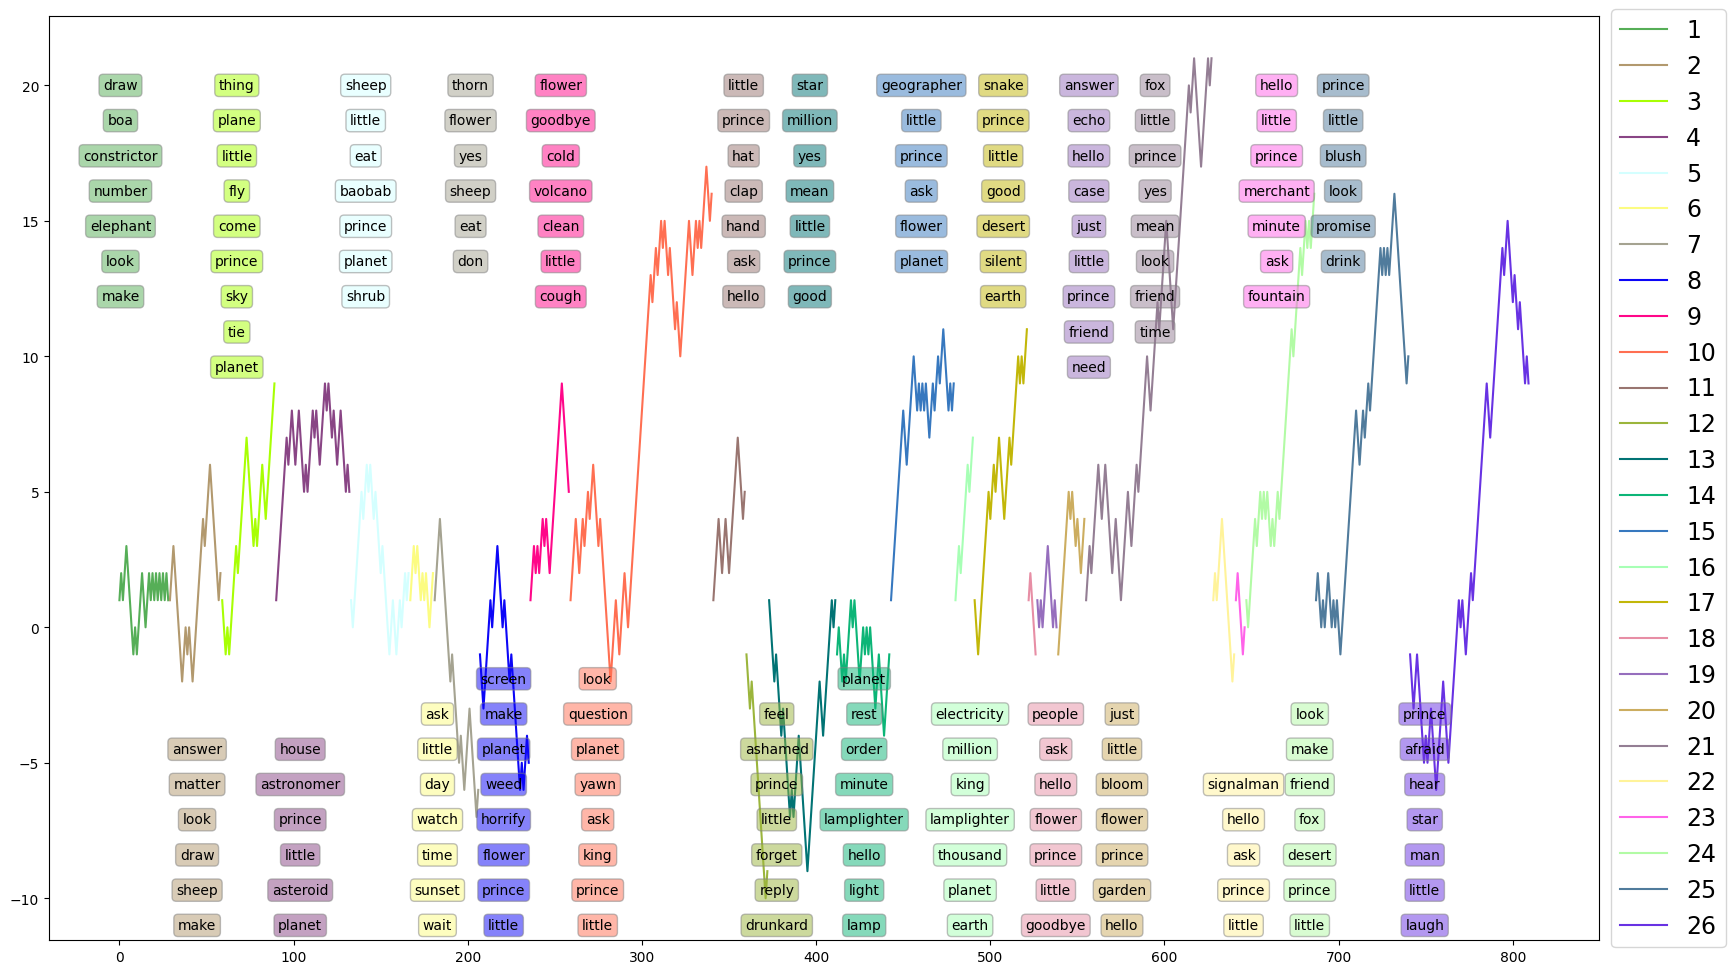

In [76]:
# automatic result plot
from random import choice
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

colours = mcolors._colors_full_map # This is a dictionary of all named colours
# Turn the dictionary into a list
color_lst = list(colours.values()) 

plt.figure(figsize=(20,12))
count = 0 
for i in range(1, len(cum_senti_lab_record)+1):
  my_list = [j for j in range(count, count + len(cum_senti_lab_record[i]))]
  plt.plot(my_list, list(cum_senti_lab_record[i]), label=str(i), color=cl[i-1])
  count += len(cum_senti_lab_record[i])
# plt.text(0.5, 0.5, 'matplotlib', horizontalalignment='center',
#      verticalalignment='center')
x_now = 0.6
for cha in key_chara.keys():
  list_chara = key_chara[cha]
  y_odd = 20
  y_even = -11
  for i_num in range(len(list_chara)):
    if cha % 2 != 0:
      plt.text(x_now, y_odd, list_chara[i_num], size=10, rotation=0.,
              ha="center", va="center",
              bbox=dict(boxstyle="round",
              ec=(0.5, 0.5, 0.5),
              facecolor=cl[cha-1],
              alpha=0.5,
                        )
              )
      last_x_odd = x_now
    else:
      plt.text(x_now, y_even, list_chara[i_num], size=10, rotation=0.,
              ha="center", va="center",
              bbox=dict(boxstyle="round",
              ec=(0.5, 0.5, 0.5),
              facecolor=cl[cha-1],#color_lst[3*cha],
              alpha=0.5,
                        )
              )
      last_x_even = x_now
    y_odd -= 1.3
    y_even += 1.3
  if cha % 2 != 0:
    x_now = max(sum([len(cum_senti_lab_record[cc]) for cc in range(1, cha+1)]) + 0.6*len(cum_senti_lab_record[i_num+1]), last_x_odd + 19)
  else:
    x_now = max(sum([len(cum_senti_lab_record[cc]) for cc in range(1, cha+1)]) + 0.6*len(cum_senti_lab_record[i_num+1]), last_x_even + 19)


# plt.text(30, 10, list_chara[0], size=6, rotation=0.,
#         ha="center", va="center",
#         bbox=dict(boxstyle="round",
#                   ec=(0.5, 0.5, 0.5),
#                   facecolor='white',
#                   alpha=0.8,
#                   )
#         )

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop = { "size": 17 })

## Manual Select key Words

In [79]:
manual_key_chara = {1: ['boa', 'constrictor', 'elephant'],
           2: ['sheep', 'draw', 'matter', 'answer'],
           3: ['plane', 'fly', 'come',  'prince',  'sky',  'tie',  'planet'],
          4: ['planet', 'asteroid', 'prince', 'astronomer', 'house'],
          5: ['sheep', 'eat', 'baobab', 'prince', 'planet', 'shrub'],
          6: ['wait', 'sunset', 'time', 'watch', 'day', 'ask'],
          7: ['thorn', 'flower', 'yes', 'sheep', 'eat'],
          8: ['prince', 'flower',  'horrify',  'weed',  'planet',  'make',  'screen'],
          9: ['flower', 'goodbye', 'cold', 'volcano', 'clean', 'cough'],
          10: ['prince', 'king', 'ask', 'yawn', 'planet', 'question', 'look'],
          11: ['prince', 'hat', 'clap', 'hand', 'ask', 'hello'],
          12: ['drunkard', 'reply', 'forget', 'prince', 'ashamed', 'feel'],
          13: ['star', 'million', 'yes', 'mean', 'prince', 'good'],
          14: ['lamp',  'light',  'hello',  'lamplighter',  'minute',  'order',  'rest',  'planet'],
          15: ['geographer', 'prince', 'ask', 'flower', 'planet'],
          16: ['earth',  'planet',  'thousand',  'lamplighter',  'king',  'million',  'electricity'],
          17: ['snake', 'prince', 'good', 'desert', 'silent', 'earth'],
          18: ['goodbye', 'prince', 'flower', 'hello', 'ask', 'people'],
          19: ['answer',  'echo',  'hello',  'case', 'prince',  'friend',  'need'],
          20: ['hello', 'garden', 'prince', 'flower', 'bloom', 'little', 'just'],
          21: ['fox', 'prince', 'yes', 'mean', 'look', 'friend', 'time'],
          22: ['prince', 'ask', 'hello', 'signalman'],
          23: ['hello', 'prince', 'merchant', 'minute', 'ask', 'fountain'],
          24: ['desert', 'fox', 'friend', 'make', 'look'],
          25: ['prince', 'blush',  'promise', 'drink'],
          26: ['laugh', 'man', 'star', 'hear', 'afraid', 'prince']}

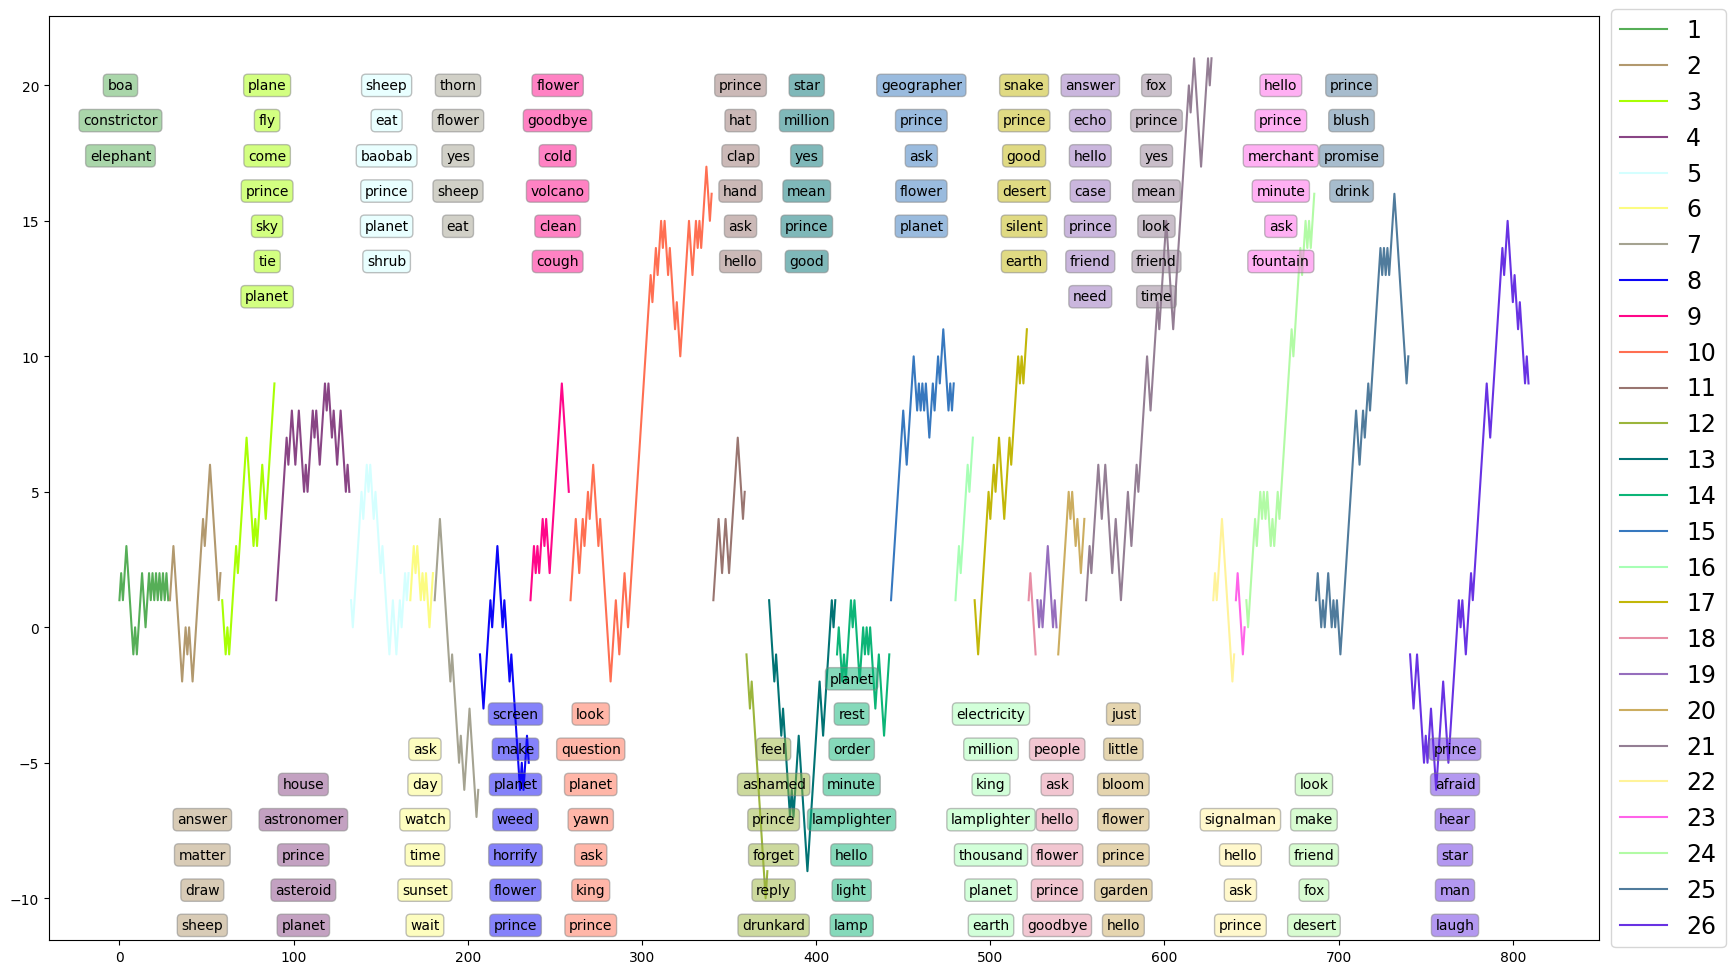

In [80]:
# automatic result plot
from random import choice
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

colours = mcolors._colors_full_map # This is a dictionary of all named colours
# Turn the dictionary into a list
color_lst = list(colours.values()) 

plt.figure(figsize=(20,12))
count = 0 
for i in range(1, len(cum_senti_lab_record)+1):
  my_list = [j for j in range(count, count + len(cum_senti_lab_record[i]))]
  plt.plot(my_list, list(cum_senti_lab_record[i]), label=str(i), color=cl[i-1])
  count += len(cum_senti_lab_record[i])
# plt.text(0.5, 0.5, 'matplotlib', horizontalalignment='center',
#      verticalalignment='center')
x_now = 0.6
for cha in manual_key_chara.keys():
  list_chara = manual_key_chara[cha]
  y_odd = 20
  y_even = -11
  for i_num in range(len(list_chara)):
    if cha % 2 != 0:
      plt.text(x_now, y_odd, list_chara[i_num], size=10, rotation=0.,
              ha="center", va="center",
              bbox=dict(boxstyle="round",
              ec=(0.5, 0.5, 0.5),
              facecolor=cl[cha-1],
              alpha=0.5,
                        )
              )
      last_x_odd = x_now
    else:
      plt.text(x_now, y_even, list_chara[i_num], size=10, rotation=0.,
              ha="center", va="center",
              bbox=dict(boxstyle="round",
              ec=(0.5, 0.5, 0.5),
              facecolor=cl[cha-1],#color_lst[3*cha],
              alpha=0.5,
                        )
              )
      last_x_even = x_now
    y_odd -= 1.3
    y_even += 1.3
  if cha % 2 != 0:
    x_now = max(sum([len(cum_senti_lab_record[cc]) for cc in range(1, cha+1)]) + 0.6*len(cum_senti_lab_record[i_num+1]), last_x_odd + 19)
  else:
    x_now = max(sum([len(cum_senti_lab_record[cc]) for cc in range(1, cha+1)]) + 0.6*len(cum_senti_lab_record[i_num+1]), last_x_even + 19)


# plt.text(30, 10, list_chara[0], size=6, rotation=0.,
#         ha="center", va="center",
#         bbox=dict(boxstyle="round",
#                   ec=(0.5, 0.5, 0.5),
#                   facecolor='white',
#                   alpha=0.8,
#                   )
#         )

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop = { "size": 17 })